In [370]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [371]:
import numpy as np
import matplotlib.pyplot as plt

import dedalus.public as d3

import logging
logger = logging.getLogger(__name__)

In [372]:
import matplotlib.pyplot as mpl
mpl.rcParams['font.size'] = 14

In [373]:
# parameters
N = 1.3e-3 # buoyancy frequency
f = -5.3e-5 # Coriolis parameter
θ = 1.26e-3 # slope angle

κ0 = 5.3e-5 # background diffusivity
κ1 = 1.8e-3 # bottom enhancement of diffusivity
h = 230. # decay scale of mixing
σ = 1 # Prandtl number

H = 3000. # domain height

Verify the solution by comparing against [Callies' (2018)](https://journals.ametsoc.org/view/journals/phoc/48/9/jpo-d-18-0082.1.xml) asymptotic analytical solution (valid here since $\delta \ll h$). 

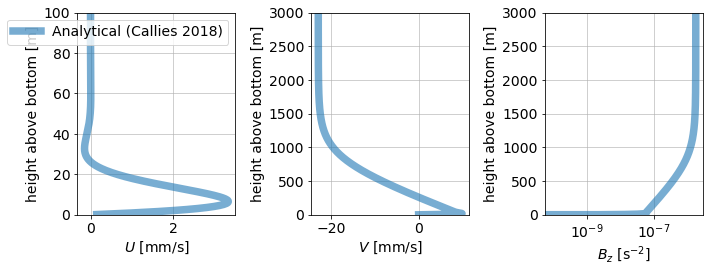

In [374]:
from bml_1d_LBVP_approx import *
bml = bbl_exp(k0=κ0, k1=κ1, h=h, N=N, f=f, θ=θ, H=H, dz=0.25)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(bml['u']*1e3, bml['z'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.ylim(0, 100)
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$U$ [mm/s]")
plt.grid(True, alpha=0.75)
plt.legend()

plt.subplot(1,3,2)
plt.plot(bml['v']*1e3, bml['z'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.ylim(0, H)
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$V$ [mm/s]")
plt.grid(True, alpha=0.75)

plt.subplot(1,3,3)
plt.plot(bml['Bz'], bml['zf'], label="Analytical (Callies 2018)", lw=7.5, alpha=0.6)
plt.ylim(0, H)
plt.xscale("log")
plt.ylabel("height above bottom [m]")
plt.xlabel(r"$B_{z}$ [s$^{-2}$]")
plt.grid(True, alpha=0.75)
plt.grid(True, which="minor", alpha=0.3)

plt.tight_layout()

In [375]:
x = np.arange(0., 500.e3, 1000)

In [376]:
zbot = x*np.tan(θ)

In [377]:
z = np.arange(0., 2500., 1.)

V = np.zeros((z.size, x.size))
U = np.zeros((z.size, x.size))
B = np.zeros((z.size, x.size))
b = np.zeros((z.size, x.size))

for i in range(x.size):
    V[:, i] = np.interp(z-zbot[i], bml['z'], bml['v'], left=np.nan, right=np.nan)
    U[:, i] = np.interp(z-zbot[i], bml['z'], bml['u'], left=np.nan, right=np.nan)
    b[:, i] = np.interp(z-zbot[i], bml['z'], bml['b'], left=np.nan, right=np.nan)
    B[:, i] = np.interp(z-zbot[i], bml['z'], bml['b'], left=np.nan, right=np.nan) + N**2*z
B[b==0.] = 0.

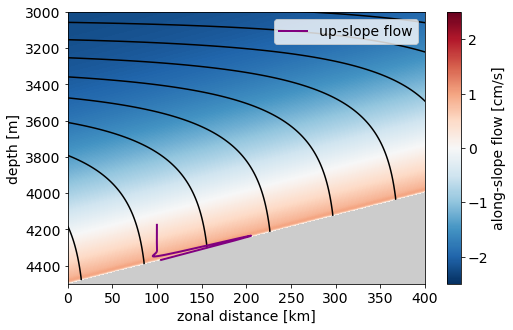

In [378]:
import matplotlib.cm as cm
dcmap = cm.get_cmap(name='RdBu_r').copy()
dcmap.set_bad(color=(0.8, 0.8, 0.8), alpha=1.)

i = 100
Δt = 365*86400.

plt.figure(figsize=(8,5))
plt.pcolormesh(x*1e-3, 4500-z, np.ma.masked_invalid(V)*1e2, cmap=dcmap, vmin=-2.5, vmax=2.5)
plt.colorbar(label="along-slope flow [cm/s]")
plt.contour(x*1e-3, 4500-z, B, levels=20, colors="k", linestyles="solid")

zplot = np.arange(0., 200., 0.5)
Δx = np.interp(zplot, bml['z'], bml['u']) * Δt
xnew = x[i] + Δx
plt.plot(xnew*1e-3, 4500 - (xnew*np.tan(θ) + zplot), color="purple", lw=2., label="up-slope flow")

plt.ylim(4500, 3000)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.legend(loc="upper right");
plt.xlim(0, 400)
plt.savefig("../figures/BML_2d_sloping.png", bbox_inches="tight", dpi=150)

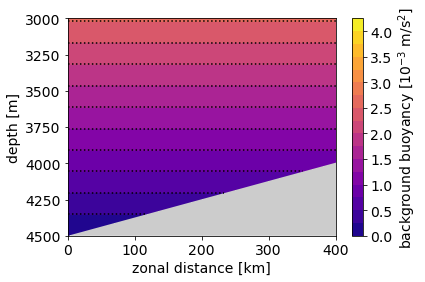

In [379]:
nancol = (0.8, 0.8, 0.8)
cmap = cm.get_cmap(name='plasma').copy()
cmap.set_bad(color=nancol, alpha=1.)

cs = plt.contourf(x*1e-3, 4500 - z, np.ma.masked_invalid(B-b)*1e3, 20, cmap=cmap)
plt.contour(x*1e-3, 4500 - z, np.ma.masked_invalid(B-b)*1e3, 20, colors="k", linestyles="dotted")
plt.colorbar(cs, label=r"background buoyancy [10$^{-3}$ m/s$^{2}$]")
plt.fill_between(x*1e-3, 4500 - np.zeros_like(zbot), 4500 - zbot, facecolor=nancol)
plt.xlim(0, 400)
plt.ylim(4500, 3000)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.savefig("../figures/BML_1d_background_sloping.png", bbox_inches="tight", dpi=150)

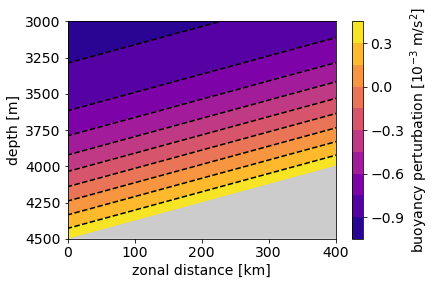

In [380]:
cs = plt.contourf(x*1e-3, 4500 - z, b*1e3, 10, cmap=cmap)
plt.contour(x*1e-3, 4500 - z, b*1e3, 10, colors="k", linestyles="dashed")
plt.colorbar(cs, label=r"buoyancy perturbation [10$^{-3}$ m/s$^{2}$]")
plt.fill_between(x*1e-3, 4500 - np.zeros_like(zbot), 4500 - zbot, facecolor=nancol)
plt.ylim(4500, 3000)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.xlim(0, 400)
plt.savefig("../figures/BML_1d_sloping.png", bbox_inches="tight", dpi=150)

In [381]:
bflat = np.zeros((z.size, x.size))

for i in range(x.size):
    bflat[:, i] = np.interp(z, bml['z'], bml['b'], left=np.nan, right=np.nan)


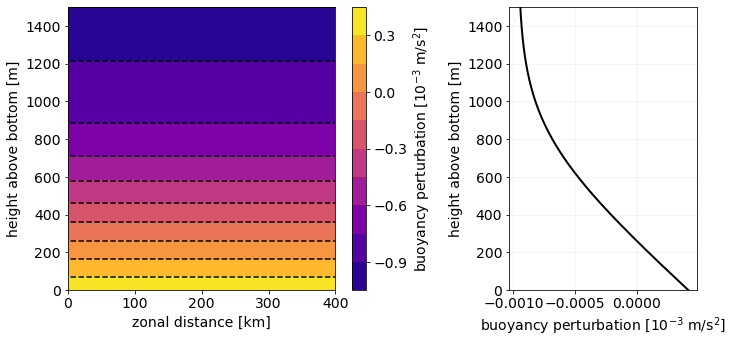

In [382]:
fig = plt.figure(figsize=(10, 5))
spec = fig.add_gridspec(1, 5)

ax = fig.add_subplot(spec[0, 0:3])
cs = ax.contourf(x*1e-3, z, bflat*1e3, 10, cmap=cmap)
ax.contour(x*1e-3, z, bflat*1e3, 10, colors="k", linestyles="dashed")
plt.colorbar(cs, ax=ax, label=r"buoyancy perturbation [10$^{-3}$ m/s$^{2}$]")
ax.set_ylim(0, 1500)
ax.set_xlabel("zonal distance [km]")
ax.set_ylabel("height above bottom [m]")
ax.set_xlim(0, 400)

ax = fig.add_subplot(spec[0, 3:])
ax.plot(bml['b'], bml['z'], "k-", lw=2)
ax.set_ylim(0, 1500)
ax.set_xlabel(r"buoyancy perturbation [10$^{-3}$ m/s$^{2}$]")
ax.set_ylabel("height above bottom [m]")
ax.grid(True, alpha=0.15)

plt.tight_layout(w_pad=1.1)
plt.savefig("../figures/BML_1d.png", bbox_inches="tight", dpi=150)